In [1]:
from warnings import simplefilter 
import os
simplefilter(action='ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3" 
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from kvae.KalmanVariationalAutoencoder import KalmanVariationalAutoencoder
from kvae.utils import reload_config, get_image_config

%matplotlib inline
plt.style.use("seaborn-white")

In [3]:
logdir = Path("../examples/logs/2dspring_success_kvae/model.ckpt")

In [4]:
!ls ../examples/logs/2dspring_imputation_success_kvae/ | grep .ckpt

model.ckpt.data-00000-of-00001
model.ckpt.index
model.ckpt.meta


In [5]:
tf.app.flags.DEFINE_string('f', '', 'kernel')

In [6]:
config = get_image_config()
# To reload a saved model
config = reload_config(config.FLAGS)

In [7]:
config.reload_model = str(logdir)
config.batch_size = 32
config.dataset = "spring_kfixlfix"
config.K = 7
# config.dim_a = 16

In [8]:
sess = tf.Session()
model = KalmanVariationalAutoencoder(config, sess)
model.build_model().build_loss().initialize_variables()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions f

In [9]:
mask_test = np.ones((model.config.batch_size, model.test_data.timesteps), dtype=np.float32)
# mask_test[:, 20:60] = 0
num_batches = model.test_data.sequences // model.config.batch_size
x_hat, smooth, a_seq, a_mu, a_var, a_mu_pred_seq, x_gene = [], [], [], [], [], [], []
for i in range(num_batches):
    slc = slice(i * model.config.batch_size, (i + 1) * model.config.batch_size)
    feed_dict = {model.x: model.test_data.images[slc],
                 model.kf.u: model.test_data.controls[slc],
                 model.ph_steps: model.test_data.timesteps,
                 model.mask: mask_test}
    x_hat_, smooth_, a_seq_, a_mu_, a_var_, a_mu_pred_seq_ = sess.run(
        [
            model.model_vars["x_hat"],         # x <- a <- x
            model.model_vars["smooth"][0],     # z <- a <- x
            model.model_vars["a_seq"],         # a <- x (sequential)
            model.model_vars["a_mu"],          # a <- x (squeezed)
            model.model_vars["a_var"],         # a <- x (var)
            model.model_vars["a_mu_pred_seq"]  # a <- z <- a <- x
        ],
        feed_dict=feed_dict)
    x_gene_ = sess.run(model.model_vars["x_hat"], feed_dict={model.model_vars["a_seq"]: a_mu_pred_seq_,
                                                           model.ph_steps: model.n_steps_gen})
    x_hat.append(x_hat_)
    smooth.append(smooth_)
    a_seq.append(a_seq_)
    a_mu.append(a_mu_)
    a_var.append(a_var_)
    a_mu_pred_seq.append(a_mu_pred_seq_)
    x_gene.append(x_gene_)

In [10]:
x_hat_seq = np.vstack(x_hat)
smooth = np.vstack(smooth)
a_seq = np.vstack(a_seq)
a_mu = np.vstack(a_mu)
a_var = np.vstack(a_var)
a_mu_pred_seq = np.vstack(a_mu_pred_seq)
x_gene_seq = np.vstack(x_gene)

出力を保存

In [54]:
!mkdir outputs

In [56]:
np.save("outputs/2dspring_2dim_zsmooth.npy", smooth)

In [12]:
shape = a_seq.shape[:-1]

In [13]:
shape

(96, 80)

生成画像

In [14]:
x_hat = x_hat_seq.reshape(-1, 64, 64)
x_hat.shape

(7680, 64, 64)

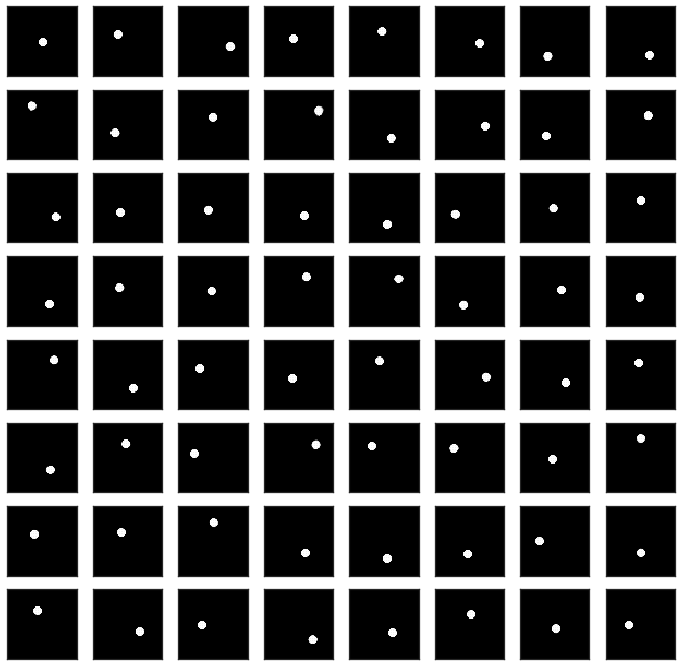

In [15]:
n = x_hat.shape[0]
h, w = 8, 8
fig, axes = plt.subplots(h, w, figsize=(12, 12))
indices = np.random.choice(n, (h, w), replace=False)
for i in range(h):
    for j in range(w):
        idx = indices[i, j]
        ax = axes[i, j]
        ax.imshow(x_hat[idx], "gray")
        ax.set_xticks([])
        ax.set_yticks([])

In [16]:
x_gene = x_gene_seq.reshape(-1, 64, 64)
x_gene.shape

(7680, 64, 64)

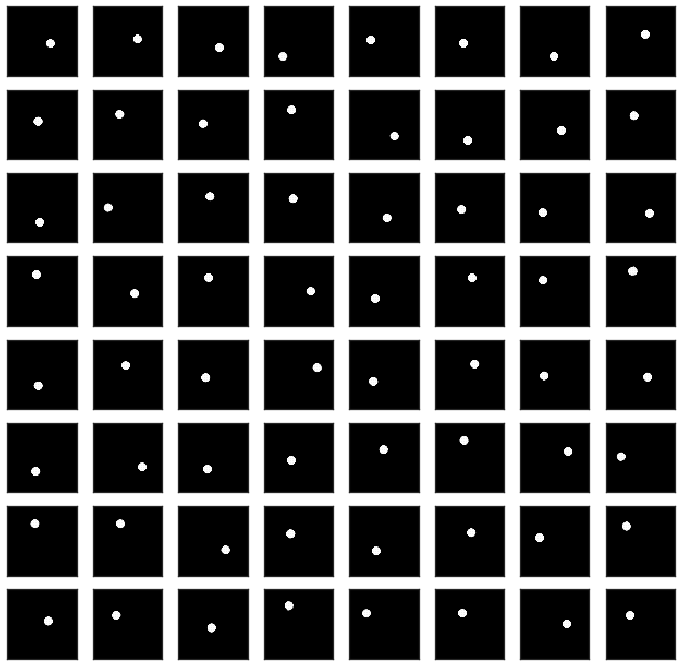

In [17]:
n = x_gene.shape[0]
h, w = 8, 8
fig, axes = plt.subplots(h, w, figsize=(12, 12))
indices = np.random.choice(n, (h, w), replace=False)
for i in range(h):
    for j in range(w):
        idx = indices[i, j]
        ax = axes[i, j]
        ax.imshow(x_gene[idx], "gray")
        ax.set_xticks([])
        ax.set_yticks([])

ハミング距離

In [18]:
def hamming_distance(x, y, thresh=0.5):
    x = (x > thresh)
    y = (y > thresh)
    d = np.mean(np.sum(np.logical_xor(x, y), axis=(-1, -2)))
    return d

In [19]:
x = model.test_data.images[:x_gene_seq.shape[0]].reshape(-1, 64, 64)

In [20]:
# x, a, x
hamming_distance(x, x_hat)

1.4713541666666667

In [21]:
# x, a, z, a, x
hamming_distance(x, x_gene)

2.2436197916666667

In [20]:
z_mu = smooth.reshape(-1, 4)

In [23]:
model.enc_shape

[8, 8, 32]

In [24]:
sess.close()

# 分析

In [13]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

In [27]:
a_mu.shape

(7680, 2)

In [29]:
pca = PCA(a_mu.shape[-1])
a_pca = pca.fit_transform(a_mu)

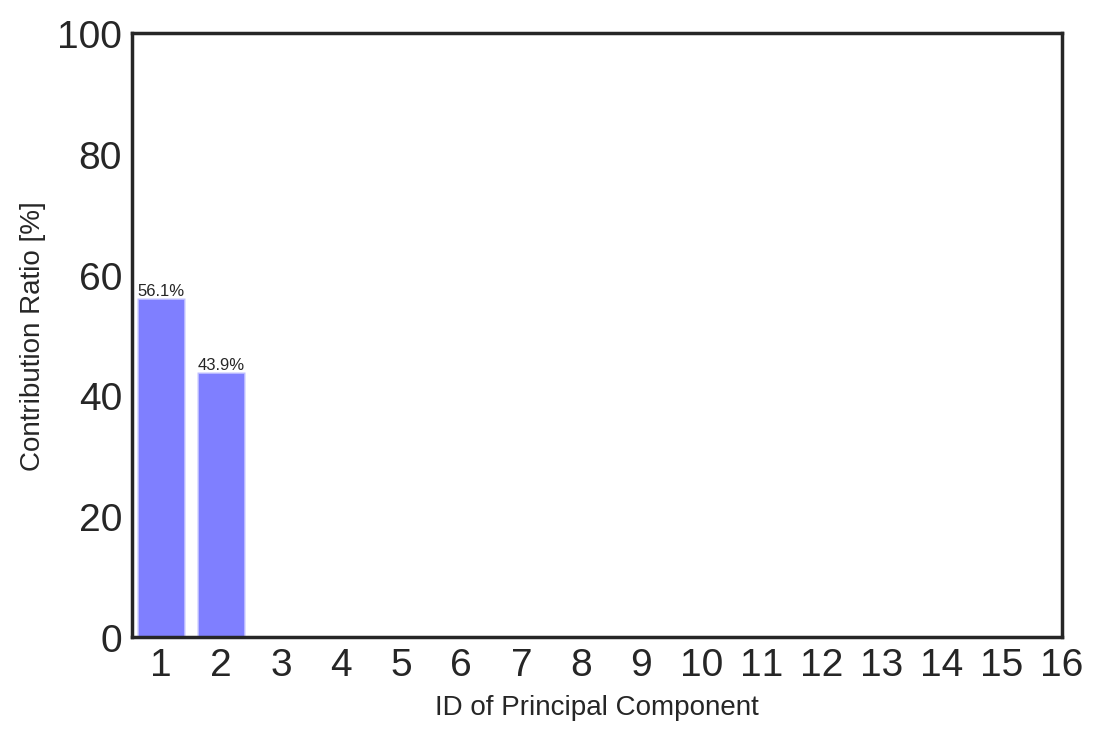

In [30]:
t = np.arange(pca.n_components)
c = pca.explained_variance_ratio_

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.bar(t+1, c*100, color="blue", alpha=0.5)
ax.set_xlabel("ID of Principal Component")
ax.set_ylabel("Contribution Ratio [%]")
for i in t:
    ax.text(i+1, c[i]*100, "{:.1f}%".format(c[i]*100), ha="center", va="bottom", fontsize=6)
ax.set_xticks(range(1, 17))
ax.set_ylim(0, 100)
print()

In [48]:
a_mu.shape

(7680, 16)

(0.0, 8.0, 8.0, 0.0)

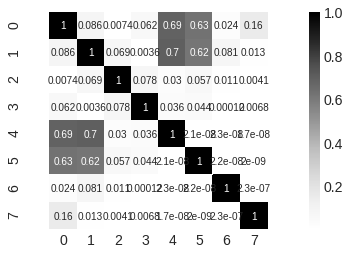

In [49]:
pos_true = model.test_data.state[:96].reshape(-1, 2)
vel_true = model.test_data.velocity[:96].reshape(-1, 2)
s_true = np.hstack([pos_true, vel_true])
a_pred = a_pca[:, :4]
R = np.corrcoef(np.hstack([s_true, a_pred]), rowvar=False)
sns.heatmap(np.abs(R), square=True, cmap="Greys", annot=True)
# sns.heatmap(R, square=True, cmap="coolwarm", annot=True)
plt.axis("equal")

In [50]:
model.test_data.velocity.shape

(100, 80, 2)

## 線形性

In [16]:
n = model.config.batch_size*num_batches

In [17]:
states = np.concatenate([model.test_data.state[:n], model.test_data.velocity[:n]], axis=2)
x_mu = states.reshape(-1, 4)

In [18]:
pca = PCA(2)
a_pca = pca.fit_transform(a_mu)

In [19]:
pca = PCA(4)
z_pca = pca.fit_transform(z_mu)

NameError: name 'z_mu' is not defined

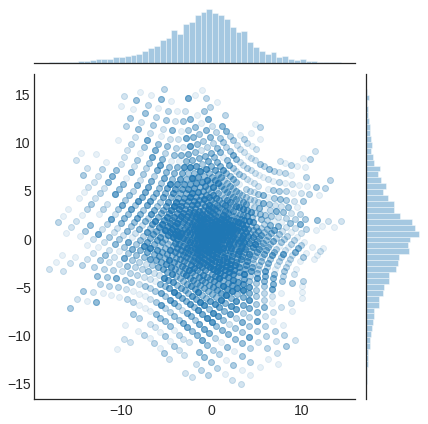

In [38]:
sns.jointplot(*a_mu.T, alpha=0.1)

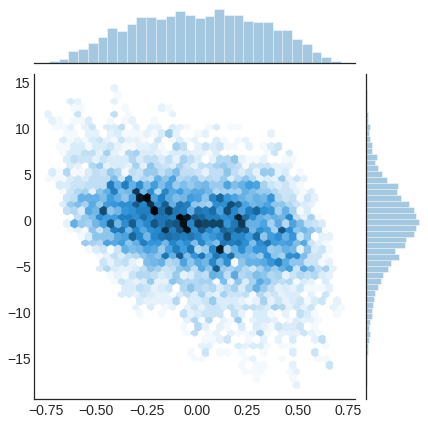

In [39]:
sns.jointplot(x_mu[:, 0], a_mu[:, 0], kind="hex")

In [21]:
from sklearn.preprocessing import StandardScaler
def stdr(x):
    return StandardScaler().fit_transform(x)

In [22]:
x_pca = PCA(x_mu.shape[-1]).fit_transform(stdr(x_mu))[:, :4]  # 4
a_pca = PCA(a_mu.shape[-1]).fit_transform(stdr(a_mu))[:, :2]  # 2
z_pca = PCA(z_mu.shape[-1]).fit_transform(stdr(z_mu))[:, :4]  # 4

(0.0, 10.0, 10.0, 0.0)

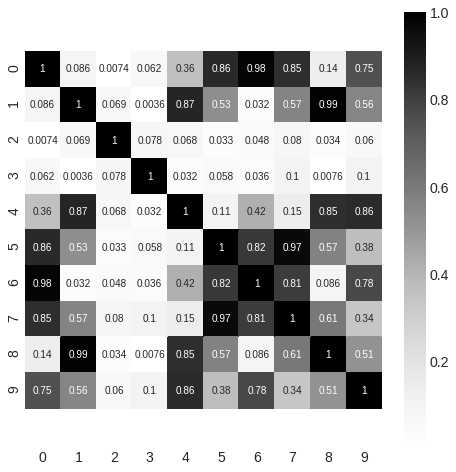

In [23]:
# z_mu
plt.figure(figsize=(8, 8))
R = np.corrcoef(np.hstack([x_mu, a_mu, z_mu]), rowvar=False)
sns.heatmap(np.abs(R), square=True, cmap="Greys", annot=True)
# sns.heatmap(R, square=True, cmap="coolwarm", annot=True)
plt.axis("equal")

In [27]:
x_mu.shape

(7680, 4)

In [29]:
def affine(x, y):
    # y = Ax + b
    mx = np.mean(x, axis=0)
    my = np.mean(y, axis=0)
    sxx = np.mean(np.einsum("ij,ik->ijk", x-mx, x-mx), axis=0)
    sxy = np.mean(np.einsum("ij,ik->ijk", x-mx, y-my), axis=0)
    A = sxy.T @ np.linalg.inv(sxx)
    b = my - mx @ A.T
    return A, b

In [33]:
A, b = affine(a_pca, x_mu[:, :2])
a_affine = a_pca @ A.T + b
z_affine = np.zeros_like(z_pca)
A, b = affine(z_pca[:, :2], x_mu[:, :2])
z_affine[:, :2] = z_pca[:, :2] @ A.T + b
A, b = affine(z_pca[:, 2:], x_mu[:, 2:])
z_affine[:, 2:] = z_pca[:, 2:] @ A.T + b

([], <a list of 0 Text yticklabel objects>)

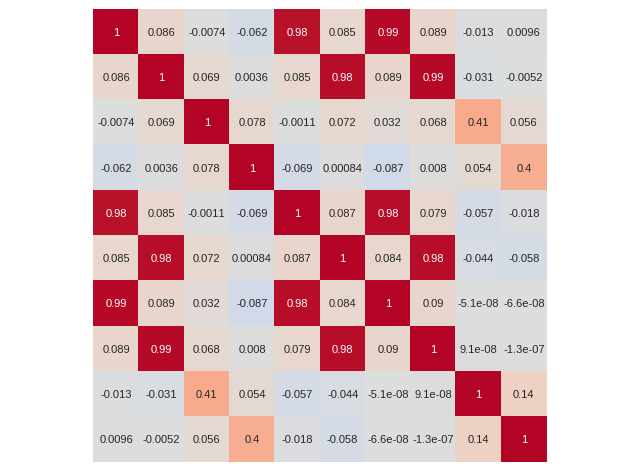

In [40]:
# z_pca
plt.figure(figsize=(8, 6), dpi=100)
R = np.corrcoef(np.hstack([x_mu, a_affine, z_affine]), rowvar=False)
# sns.heatmap(np.abs(R), square=True, cmap="Greys", annot=True)
sns.heatmap(R, square=True, cmap="coolwarm", annot=True, vmin=-1, vmax=1, annot_kws={"size": 8}, cbar=False)
plt.axis("equal")
plt.xticks([])
plt.yticks([])

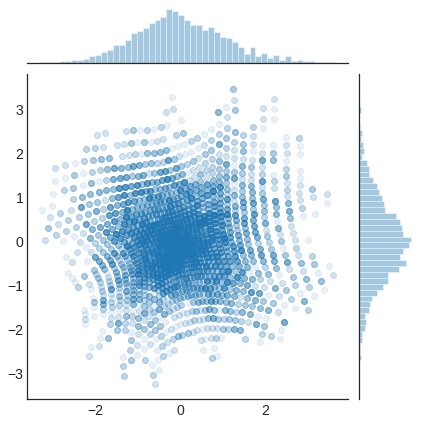

In [44]:
sns.jointplot(*a_pca.T, alpha=0.1)

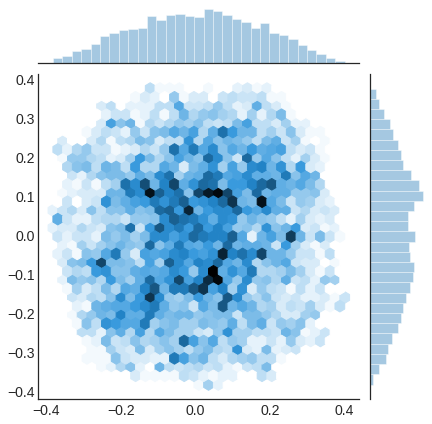

In [45]:
sns.jointplot(*x_mu[:, 2:].T, kind="hex")

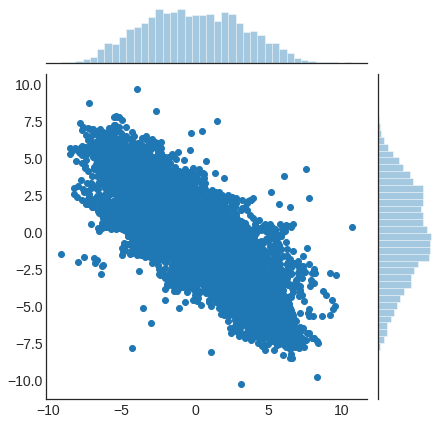

In [46]:
sns.jointplot(*z_mu[:, :2].T, kind="scatter")

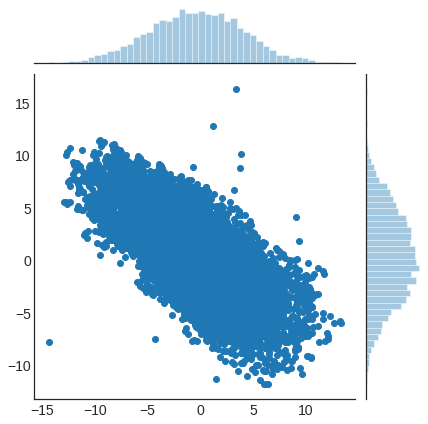

In [37]:
sns.jointplot(*z_mu[:, 2:].T, kind="scatter")

In [48]:
def affine(x, y):
    mu_x = np.mean(x, axis=0)
    mu_y = np.mean(y, axis=0)
    ex, ey = x - mu_x, y - mu_y
    cov_xx = np.mean(np.einsum("...i,...j->...ij", ex, ex), axis=0)
    cov_xy = np.mean(np.einsum("...i,...j->...ij", ex, ey), axis=0)
    A = cov_xy.T @ np.linalg.inv(cov_xx)
    b = mu_y - mu_x @ A.T
    return A, b

(-0.3154820278286934,
 0.4034946337342262,
 -0.44364173263311385,
 0.4518382355570793)

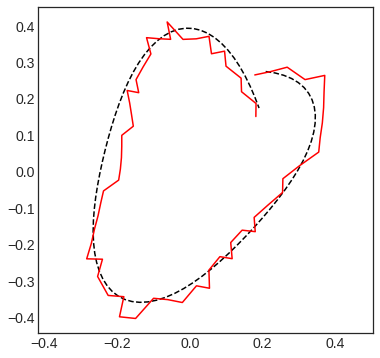

In [52]:
idx = 5
A, b = affine(a_pca.reshape(*shape, 2)[idx], x_mu.reshape(*shape, 4)[idx, :, :2])
a_affine = a_pca.reshape(*shape, a_pca.shape[-1]) @ A.T + b
plt.figure(figsize=(6, 6))
plt.plot(*x_mu.reshape(*shape, 4)[idx, :, :2].T, "k--")
plt.plot(*a_affine[idx, :, :2].T, "r")
plt.axis("equal")

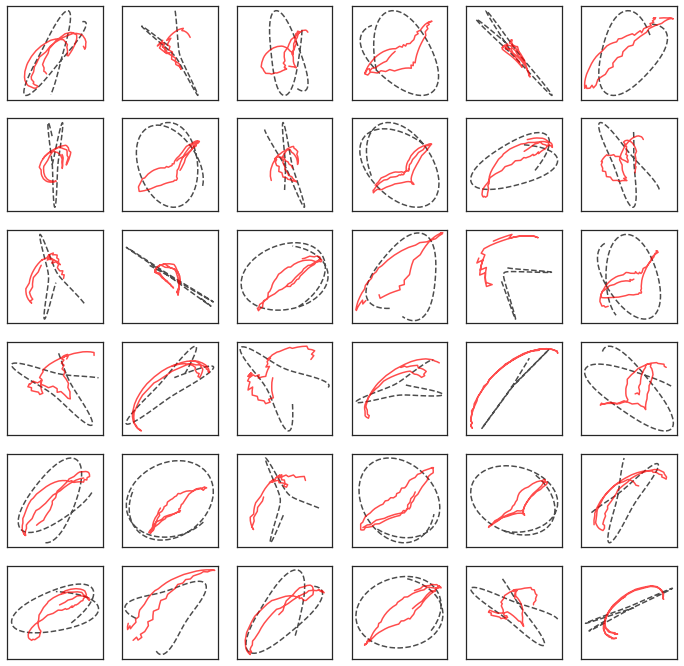

In [81]:
a = a_pca[:, :2]
x = x_mu[:, :2]
A, b = affine(a, x)
a_affine = a @ A.T + b
h, w = 6, 6
fig, axes = plt.subplots(h, w, figsize=(12, 12))
for i in range(h):
    for j in range(w):
        n = i*w + j
        slc = slice(n*model.test_data.timesteps, (n+1)*model.test_data.timesteps)
        axes[i, j].plot(*x[slc].T, "k--", alpha=0.7)
        axes[i, j].plot(*a_affine[slc].T, "r-", alpha=0.7)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].axis("equal")

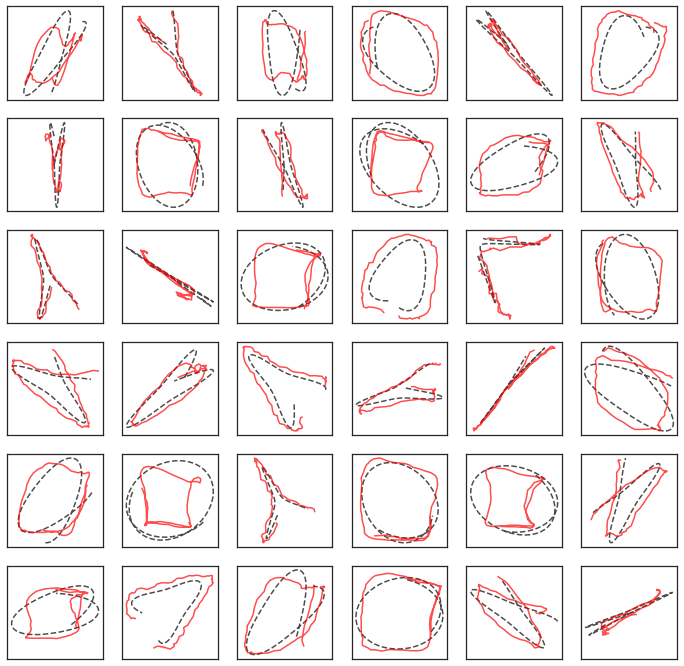

In [82]:
z = z_pca[:, :2]
x = x_mu[:, :2]
A, b = affine(z, x)
z_affine = z @ A.T + b
h, w = 6, 6
fig, axes = plt.subplots(h, w, figsize=(12, 12))
for i in range(h):
    for j in range(w):
        n = i*w + j
        slc = slice(n*model.test_data.timesteps, (n+1)*model.test_data.timesteps)
        axes[i, j].plot(*x[slc].T, "k--", alpha=0.7)
        axes[i, j].plot(*z_affine[slc].T, "r-", alpha=0.7)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].axis("equal")

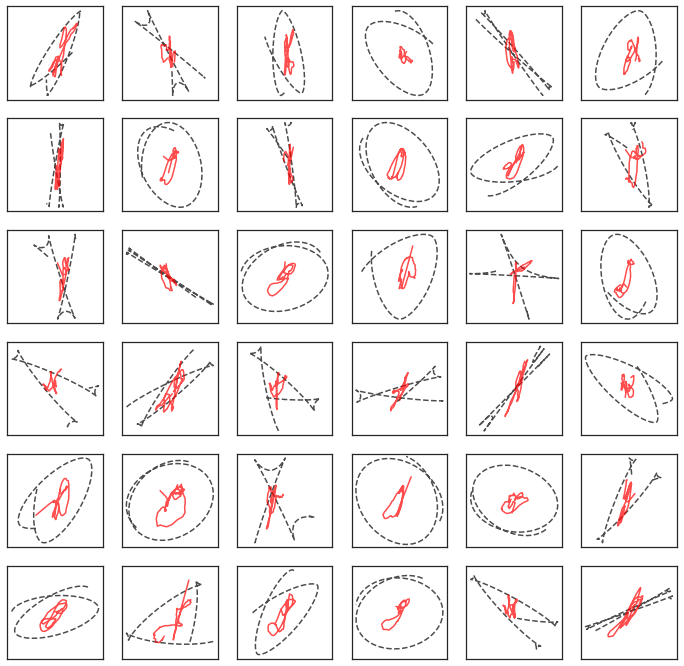

In [61]:
z = z_pca[:, 2:]
x = x_mu[:, 2:]
A, b = affine(z, x)
z_affine = z @ A.T + b
h, w = 6, 6
fig, axes = plt.subplots(h, w, figsize=(12, 12))
for i in range(h):
    for j in range(w):
        n = i*w + j
        slc = slice(n*model.test_data.timesteps+1, (n+1)*model.test_data.timesteps)
        axes[i, j].plot(*x[slc].T, "k--", alpha=0.7)
        axes[i, j].plot(*z_affine[slc].T, "r-", alpha=0.7)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].axis("equal")

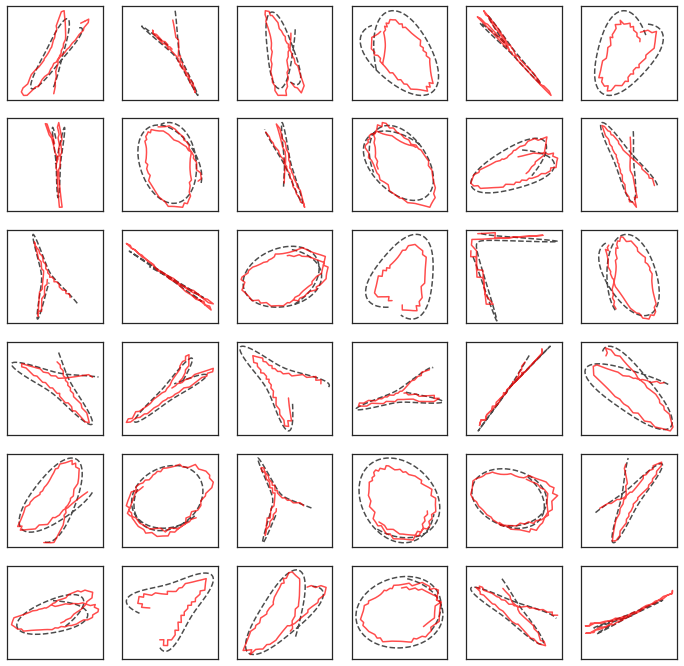

In [40]:
a = a_pca
A, b = affine(a, x_mu)
a_affine = a @ A.T + b
h, w = 6, 6
fig, axes = plt.subplots(h, w, figsize=(12, 12))
for i in range(h):
    for j in range(w):
        n = i*w + j
        slc = slice(n*model.test_data.timesteps, (n+1)*model.test_data.timesteps)
        axes[i, j].plot(*x_mu[slc, :2].T, "k--", alpha=0.7)
        axes[i, j].plot(*a_affine[slc, :2].T, "r-", alpha=0.7)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].axis("equal")

# CCA

In [48]:
n = model.config.batch_size*num_batches

In [49]:
states = np.concatenate([model.test_data.state[:n], model.test_data.velocity[:n]], axis=2)
x_mu = states.reshape(-1, 4)

In [52]:
a_cca, x_cca = CCA(2).fit_transform(stdr(a_mu), stdr(x_mu))
a_cca = a_cca*np.std(x_cca, axis=0)/np.std(a_cca, axis=0)

### a -> x

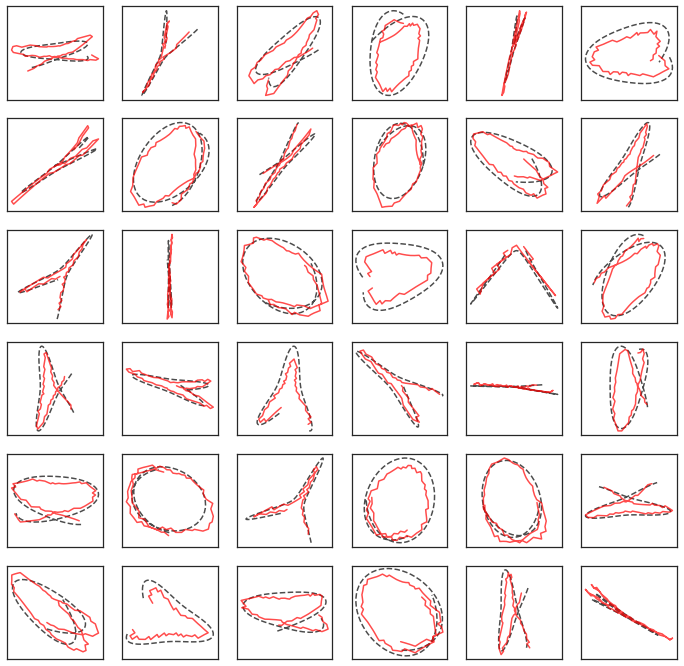

In [53]:
h, w = 6, 6
fig, axes = plt.subplots(h, w, figsize=(12, 12))
for i in range(h):
    for j in range(w):
        n = i*w + j
        slc = slice(n*model.test_data.timesteps, (n+1)*model.test_data.timesteps)
        axes[i, j].plot(*x_cca[slc, :2].T, "k--", alpha=0.7)
        axes[i, j].plot(*a_cca[slc, :2].T, "r-", alpha=0.7)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].axis("equal")

In [54]:
z_cca, x_cca = CCA(4).fit_transform(stdr(z_mu), stdr(x_mu))
z_cca = np.std(x_cca, axis=0)/np.std(z_cca, axis=0)*z_cca

### z[0:2] -> x[0:2]

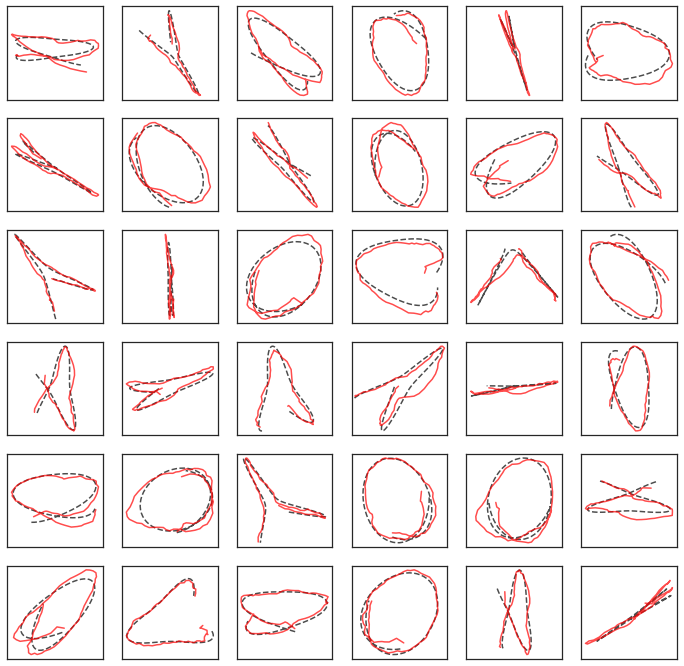

In [55]:
h, w = 6, 6
fig, axes = plt.subplots(h, w, figsize=(12, 12))
for i in range(h):
    for j in range(w):
        n = i*w + j
        slc = slice(n*model.test_data.timesteps, (n+1)*model.test_data.timesteps)
        axes[i, j].plot(*x_cca[slc, :2].T, "k--", alpha=0.7)
        axes[i, j].plot(*z_cca[slc, :2].T, "r-", alpha=0.7)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].axis("equal")

### z[2:4] -> x[2:4]

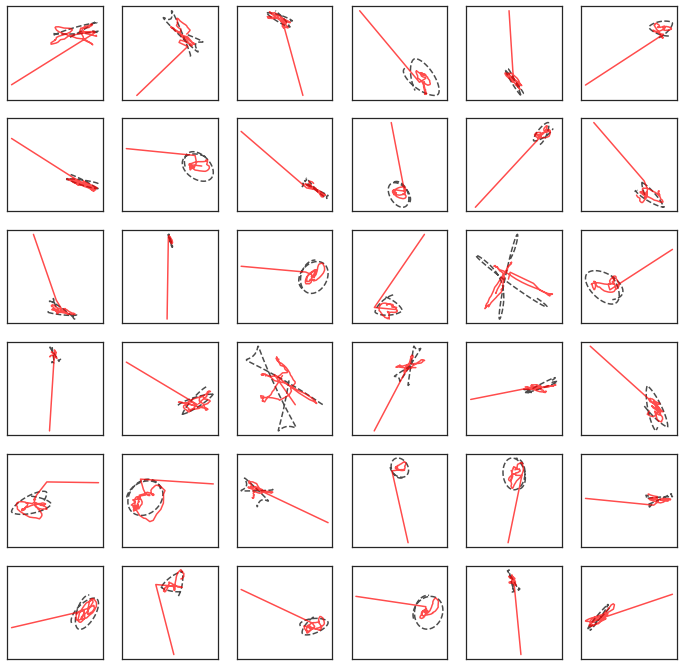

In [56]:
h, w = 6, 6
fig, axes = plt.subplots(h, w, figsize=(12, 12))
for i in range(h):
    for j in range(w):
        n = i*w + j
        slc = slice(n*model.test_data.timesteps, (n+1)*model.test_data.timesteps)
        axes[i, j].plot(*x_cca[slc, 2:].T, "k--", alpha=0.7)
        axes[i, j].plot(*z_cca[slc, 2:].T, "r-", alpha=0.7)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].axis("equal")

系列ごとにCCA

In [ ]:
h, w = 6, 6
fig, axes = plt.subplots(h, w, figsize=(12, 12))
for i in range(h):
    for j in range(w):
        n = i*w + j
        slc = slice(n*model.test_data.timesteps, (n+1)*model.test_data.timesteps)
        cca = CCA(2)
        z_cca, x_cca = cca.fit_transform(z_mu[slc, :2], x_mu[slc, :2])
        axes[i, j].plot(*x_cca.T, "k--", alpha=0.7)
        axes[i, j].plot(*z_cca.T, "r-", alpha=0.7)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].axis("equal")

In [77]:
z = z_mu[slc, :2]
x = x_mu[slc, :2]

In [79]:
cca = CCA(2)
z_cca, x_cca = cca.fit_transform(z, x)

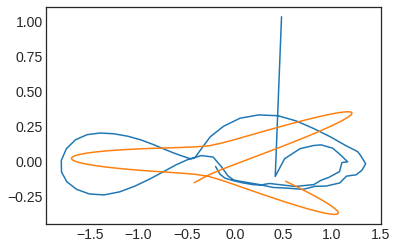

In [81]:
plt.plot(*z_cca.T)
plt.plot(*x_cca.T)